In [1]:
import numpy as np
import tensorflow as tf
import time
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

# MLP with Tensorflow
### Data generation function

In [2]:
# Generate data
def sample_data(r = 2, n = 1024, sigma = 0.35):
    n1 = np.ceil(n/2).astype(int)
    n2 = n-n1
    theta1 = np.random.uniform(low=0.0, high=2*np.pi, size=(n1,))
    theta2 = np.random.uniform(low=0.0, high=2*np.pi, size=(n2,))
    radius1 = np.random.randn(n1) * sigma + r
    radius2 = np.random.randn(n2) * 2*sigma 
    x1 = radius1*np.cos(theta1)
    y1 = radius1*np.sin(theta1)
    x2 = radius2*np.cos(theta2)
    y2 = radius2*np.sin(theta2)
    x = np.concatenate((np.stack((x1,y1),axis = 1),np.stack((x2,y2),axis = 1)),axis=0)
    label = np.concatenate((np.ones((n1,)),np.zeros((n2,))),axis=0)
    return x, label

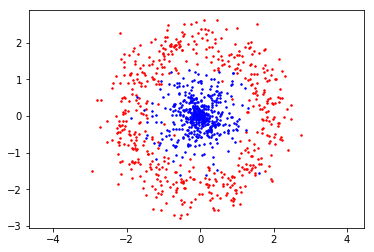

In [3]:
# Visualize data
x, label = sample_data()

plt.plot(x[label==1,0],x[label==1,1],'r.', markersize = 3)
plt.plot(x[label==0,0],x[label==0,1],'b.', markersize = 3)
plt.axis('equal');

### Build MLP discriminator 

From scratch

In [4]:
def discriminator(X,units=[8,8],reuse=False):
    with tf.variable_scope("Discriminator", reuse=reuse): # context manager, so all variables below will be grouped with a suffix "Discriminator"
        # Specify all variables
        # tf.get_variable() gets existing variable with the parameters or creates a new one; used for weight sharing
        w1 = tf.get_variable('w1', shape = [2, units[0]], dtype = tf.float32, initializer = tf.glorot_uniform_initializer)
        b1 = tf.get_variable('b1', shape = [1, units[0]], dtype = tf.float32)
        w2 = tf.get_variable('w2', shape = [units[0], units[1]], dtype = tf.float32)
        b2 = tf.get_variable('b2', shape = [1, units[1]], dtype = tf.float32)
        w3 = tf.get_variable('w3', shape = [units[1], 1], dtype = tf.float32)
        b3 = tf.get_variable('b3', shape = [1, 1], dtype = tf.float32)
        
        # Build the MLP
        h1 = tf.nn.relu(tf.matmul(X,w1)+b1)
        h2 = tf.nn.relu(tf.matmul(h1,w2)+b2)
        out = tf.matmul(h2,w3)+b3
        
    return out # Return the linear output because the loss function takes logits as input

Or use Tensorflow built-in layers

In [5]:
def discriminator(X,units=[8,8],reuse=False):
    with tf.variable_scope("Discriminator", reuse=reuse): # context manager, so all variables below will be grouped with a suffix "Discriminator"
        h1 = tf.layers.dense(X,units[0],activation=tf.nn.relu)
        h2 = tf.layers.dense(h1,units[1],activation=tf.nn.relu)
        out = tf.layers.dense(h2,1)
    return out

### Some other preparations

In [6]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [7]:
# Set up a grid of points for visualizing discriminator
grid = np.arange(-3.5, 3.5, 0.05)
xv, yv = np.meshgrid(grid, grid)
v = np.concatenate((xv.reshape(-1,1),yv.reshape(-1,1)),axis= 1)

### Construct the graph

In [8]:
# 1. Use "placeholder" as to contruct empty tensors that receive inputs (X and y)
X = tf.placeholder(tf.float32,[None,2])  # None for undetermined number: flexible sample size
y = tf.placeholder(tf.float32,[None,1])

# 2. Set the grid points into tensorflow constant
V = tf.constant(v, dtype = tf.float32)

# 3. Pass X through discriminator to obtain logits (linear output)
s_logits = discriminator(X)

# 4. Pass V through discriminator to obtain logits 
# Note: This is the second time using variables in discriminator, so set reuse = True
v_logits = discriminator(V, reuse=True)

# 5. Write down loss function
# Here I use tensorflow built-in function tf.nn.sigmoid_cross_entropy_with_logits, but one can write the loss function from scratch
# This built-in function deals with numerical instability, see line 109 of the source code
# https://github.com/tensorflow/tensorflow/blob/r1.14/tensorflow/python/ops/nn_impl.py#L108-L185
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=s_logits,labels=y))

# 6. Identify variables for optimization
disc_vars = tf.trainable_variables(scope="Discriminator")

# 7. Set up optimizer (other options: GradientDescentOptimizer, MomentumOptimizer, AdamOptimizer, etc.)
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

# 8. Use "minimize" function to optimize loss by changing the weights of selected variables
opt = optimizer.minimize(loss,var_list = disc_vars)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


### Run the training for-loop in a Tensorflow session

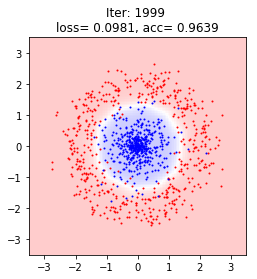

<Figure size 432x288 with 0 Axes>

In [9]:
# Set up batch size and number of epoch
batch_size = 1024
epochs = 2000
acc_list = []
loss_list = []

# Run the graph with a tensorflow session
with tf.Session() as sess:
    # At the beginning of the session, run this line to initialize
    sess.run(tf.global_variables_initializer())
    
    # Loop over epochs
    for i in range(epochs):
        # Sample from data generator
        X_batch, label = sample_data(n=batch_size)

        # Run one iteration using "run" on optimization step
        # (1) Query variables of interest by calling them in a list with the optimization
        # (2) Use "feed_dict" to feed in samples
        _, this_loss, s_log, v_log = sess.run([opt, loss, s_logits, v_logits], feed_dict={X: X_batch, y: label.reshape(-1,1)})
        
        # Collect loss and accuracy
        loss_list.append(this_loss)
        acc = np.mean((sigmoid(s_log)>0.5)==label.reshape(-1,1))
        acc_list.append(acc)

        # Visualization
        if i%100 == 0 or i == epochs-1:                        
            v_pred = sigmoid(v_log).reshape(xv.shape[0], yv.shape[0])
            extent = [-3.525, 3.525, -3.525, 3.525]
                       
            plt.clf()
            plt.imshow(v_pred, extent = extent, alpha = 0.2, cmap = 'bwr')
            plt.plot(X_batch[label==1,0],X_batch[label==1,1],'r.', markersize=2)
            plt.plot(X_batch[label==0,0],X_batch[label==0,1],'b.', markersize=2)
            plt.xlim([-3.5,3.5])
            plt.ylim([-3.5,3.5])
            plt.title("Iter: %d \nloss= %.4f, acc= %.4f"%(i,this_loss,acc));
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(0.5)

plt.clf();

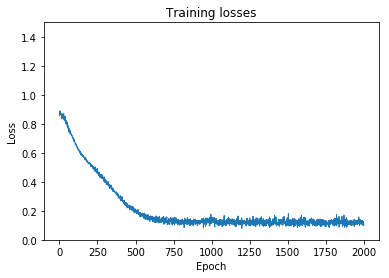

In [10]:
# Plot training loss
plt.plot(loss_list,linewidth = 1)
plt.ylim([0,1.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training losses');

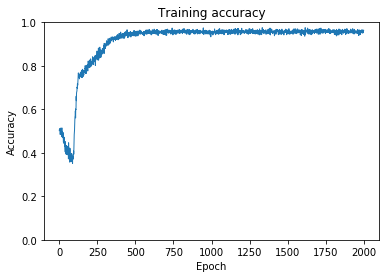

In [11]:
# Plot accuracy
plt.plot(acc_list,linewidth = 1)
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy');

In [12]:
# Reset graph
# tf.reset_default_graph()